In [1]:
import numpy as np
import numpy.random as ra
import numpy.linalg as la
import matplotlib.pyplot as plt

W = 32
H = 32

num_iterations = 300000
iterations_per_frame = 100
beta_scale = 100 # c such that maximum beta is log(1+c)

vertices = [(vr, vc) for vr in range(H) for vc in range(W)]
numv = len(vertices)

edges = [(e1r, e1c, e2r, e2c) for e1r in range(H) for e1c in range(W) for (e2r, e2c) in [(e1r, e1c+1), (e1r+1, e1c)] if e2r < H and e2c < W]
nume = len(edges)

plaquettes = [(pr, pc) for pr in range(H-1) for pc in range(W-1)]
nump = len(plaquettes)

In [28]:
# De Rham operators and Laplacians

d0 = np.array(
    [
        [
            -1 if vr == e1r and vc == e1c else 1 if vr == e2r and vc == e2c else 0
            for (vr, vc) in vertices
        ]
        for (e1r, e1c, e2r, e2c) in edges
    ]
)

d1 = np.array(
    [
        [
            1 if e1r == pr and e1c == pc and e2r == pr+1 and e2c == pc else
            1 if e1r == pr+1 and e1c == pc and e2r == pr+1 and e2c == pc+1 else
            -1 if e1r == pr and e1c == pc and e2r == pr and e2c == pc+1 else
            -1 if e1r == pr and e1c == pc+1 and e2r == pr+1 and e2c == pc+1 else 0
            for (e1r, e1c, e2r, e2c) in edges
        ]
        for (pr, pc) in plaquettes
    ]
)

dstar1 = np.transpose(d0)
dstar2 = np.transpose(d1)

L0 = dstar1 @ d0
L1 = dstar2 @ d1 + d0 @ dstar1
L2 = d1 @ dstar2

np.save(f'data/{W}x{H}/matrices/d0',d0)
np.save(f'data/{W}x{H}/matrices/d1',d1)
np.save(f'data/{W}x{H}/matrices/dstar1',dstar1)
np.save(f'data/{W}x{H}/matrices/dstar2',dstar2)
np.save(f'data/{W}x{H}/matrices/L0',L0)
np.save(f'data/{W}x{H}/matrices/L1',L1)
np.save(f'data/{W}x{H}/matrices/L2',L2)

In [2]:
# Load operators from disk instead of generating them

d0 = np.load(f'data/{W}x{H}/matrices/d0.npy')
d1 = np.load(f'data/{W}x{H}/matrices/d1.npy')
dstar1 = np.load(f'data/{W}x{H}/matrices/dstar1.npy')
dstar2 = np.load(f'data/{W}x{H}/matrices/dstar2.npy')
L0 = np.load(f'data/{W}x{H}/matrices/L0.npy')
L1 = np.load(f'data/{W}x{H}/matrices/L1.npy')
L2 = np.load(f'data/{W}x{H}/matrices/L2.npy')

In [3]:
# generate all data

beta = np.log(1 + 1/beta_scale)

theta = 2*np.pi*ra.random(numv)
m = np.round(ra.normal(- d0 @ theta / (2*np.pi), 1/(2*np.pi*np.sqrt(beta))))

def Hamiltonian(t,m):
    return np.sum((d0 @ t + 2*np.pi*m)**2)/2

Hold = Hamiltonian(theta, m)
Hnew = 0

ad = np.abs(d0)

for round in range(num_iterations):

    beta = np.log(1 + (round+1) * beta_scale / num_iterations)
    
    changedvertices = np.zeros(numv)
    changedvertices[ra.randint(numv)] = 1
    fixedvertices = 1 - changedvertices
    changededges = ad @ changedvertices
    changededges[changededges != 0] = 1
    fixededges = 1 - changededges

    proptheta = theta * fixedvertices + 2*np.pi*ra.random(numv) * changedvertices
    propm = m * fixededges + np.round(ra.normal(-d0 @ proptheta / (2*np.pi), 1/(2*np.pi*np.sqrt(beta)))) * changededges

    Hnew = Hamiltonian(proptheta, propm)

    if ra.random() < np.exp(- beta * (Hnew - Hold)):
        theta = proptheta
        m = propm
        Hold = Hnew
    
    if (round+1) % iterations_per_frame == 0:
        q = d1 @ m
        nq = la.lstsq(d1, q, rcond=None)[0]
        psi = la.lstsq(d0, m-nq, rcond=None)[0]
        phi = theta + 2*np.pi*psi + 2*np.pi*(dstar1 @ la.lstsq(L1, nq, rcond=None)[0])
        np.save(f'data/{W}x{H}/theta/{round//iterations_per_frame}', theta)
        np.save(f'data/{W}x{H}/m/{round//iterations_per_frame}', m)
        np.save(f'data/{W}x{H}/q/{round//iterations_per_frame}', q)
        np.save(f'data/{W}x{H}/phi/{round//iterations_per_frame}', phi)


KeyboardInterrupt: 

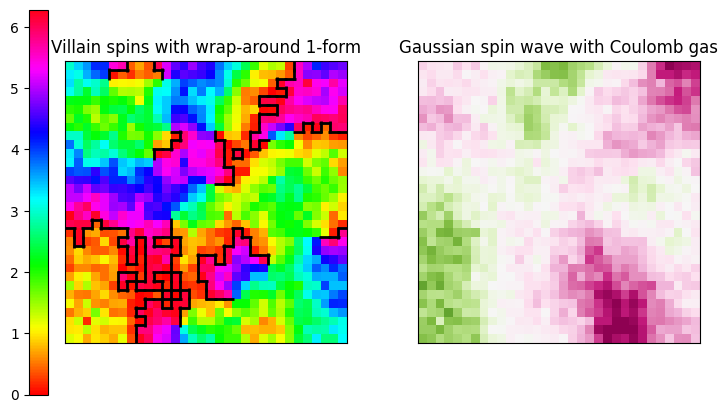

In [7]:
thetas = [np.load(f'data/{W}x{H}/theta/{i}.npy').reshape((H,W)) for i in range(num_iterations//iterations_per_frame)]
ms = [np.load(f'data/{W}x{H}/m/{i}.npy') for i in range(num_iterations//iterations_per_frame)]
qs = [np.load(f'data/{W}x{H}/q/{i}.npy').reshape((H-1,W-1)) for i in range(num_iterations//iterations_per_frame)]
phis = [np.load(f'data/{W}x{H}/phi/{i}.npy').reshape((H,W)) for i in range(num_iterations//iterations_per_frame)]


for i in range(num_iterations//iterations_per_frame):
    fig, (tviewer, pviewer) = plt.subplots(1, 2, figsize=(10,5))
    tviewer.axes.get_yaxis().set_visible(False)
    tviewer.axes.get_xaxis().set_visible(False)
    pviewer.axes.get_yaxis().set_visible(False)
    pviewer.axes.get_xaxis().set_visible(False)

    tv = tviewer.matshow(thetas[i], vmin=0, vmax=2*np.pi, cmap='hsv')
    tviewer.set_title('Villain spins with wrap-around 1-form')
    fig.colorbar(tv, ax=tviewer, location='left', pad=0.05)

    mdown =  [(e1c, e1r+0.5, ms[i][j]) for (j, (e1r, e1c, e2r, e2c)) in enumerate(edges) if e2r > e1r and ms[i][j] > 0]
    mup =  [(e1c, e1r+0.5, ms[i][j]) for (j, (e1r, e1c, e2r, e2c)) in enumerate(edges) if e2r > e1r and ms[i][j] < 0]
    mright =  [(e1c+0.5, e1r, ms[i][j]) for (j, (e1r, e1c, e2r, e2c)) in enumerate(edges) if e2c > e1c and ms[i][j] > 0]
    mleft =  [(e1c+0.5, e1r, ms[i][j]) for (j, (e1r, e1c, e2r, e2c)) in enumerate(edges) if e2c > e1c and ms[i][j] < 0]

    markers = [[(-1,0),(1,0)], [(-1,0),(1,0)], [(0,-1),(0,1)], [(0,-1),(0,1)]]

    for (d,mlist) in enumerate([mdown, mup, mright, mleft]):
        mx = [x for (x,y,c) in mlist]
        my = [y for (x,y,c) in mlist]
        mc = [np.abs(c) for (x,y,c) in mlist]
        tviewer.scatter(mx, my, c=mc, marker=markers[d], linewidth=2, s=75, vmin=1, vmax=2.5, cmap='bone')

    pv = pviewer.matshow(phis[i], vmin=0, vmax=2*np.pi, cmap='PiYG')
    pviewer.set_title('Gaussian spin wave with Coulomb gas')
    fig.colorbar(pv, ax=pviewer, location='right')

    qpoints = [(pc+0.5, pr+0.5, qs[i][pr,pc]) for (pr, pc) in plaquettes if qs[i][pr,pc] != 0]
    qx = [x for (x,y,c) in qpoints]
    qy = [y for (x,y,c) in qpoints]
    qc = [c for (x,y,c) in qpoints]
    qv = pviewer.scatter(qx, qy, c=qc, marker='o', vmin = -2, vmax = 2, cmap='seismic')

    fig.text(0.4, 0.05, f'temperature = {1/np.log(1+(i+1)*iterations_per_frame*beta_scale/num_iterations):.5f}')
    plt.tight_layout()
    plt.savefig(f'images/{W}x{H}/{i:04d}.png', bbox_inches='tight')
    plt.close('all')